In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import shap
import optuna

# Global Configuration
base_dir = Path().resolve().parent

TUNE_MODE = True # Enable Optuna tuning
N_TRIALS = 20 # Number of trial for Optuna
SEED = 42

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

2025-10-16 23:51:20.776846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 23:51:20.858705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-16 23:51:23.140845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TUNE_MODE: ON | Optuna Trials: 20


In [ ]:
# Step 1: Import the preprocessed data
df_flux = pd.read_csv(base_dir / "dataset/csv/fluxomic_features.csv", index_col=0)
df_gene = pd.read_csv(base_dir / "dataset/csv/transcriptomic_features.csv", index_col=0)
meta_data = pd.read_csv(base_dir  / "dataset/csv/metadata.csv", index_col=0)

In [ ]:
#  Step 2: Prepare data for ML models


# Remove exchange reaction
rxns = [c for c in df_flux.columns if c != "response" and not c.startswith("EX_")]
flux = df_flux[rxns]

# Select top variable fluxes by variance
fl_n = 200
fl_top = flux.var().sort_values(ascending=False).index[:fl_n]

# Select top HVG genes
tr_n = 250
hvg_genes = pd.read_csv(base_dir / "dataset/csv/hvg_genes.csv",header=None).squeeze().tolist()
tr_top = [g for g in hvg_genes if g in df_gene.columns][:tr_n]

# Build the feature matrix X_gene and X_flux using the selected top genes and fluxes
X_gene= df_gene[tr_top]
X_flux = flux[fl_top]

# Merge features from both modalities
# The merge uses the sample index (assumed unique) to align data across modalities.
X = pd.merge(X_gene, X_flux, left_index=True, right_index=True)

# Extract aligned target labels
# Ensure response column aligns perfectly with merged feature matrix
y = meta_data.loc[X.index,:]['response']


#  2.2 Encode target variable
# Convert categorical response labels to numeric (binary classification)
# 'Responder' -> 1, 'Non-responder' -> 0
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)

print(X.shape)

(51324, 450)


In [ ]:
# 2.3 Split the data into training and test sets
# Split dataset into training and test sets (80% train, 20% test)
# Stratified split ensures class balance is preserved in both subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

# 2.4 Standardize the features
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Step 3: Optuna for Hyper-parameter tunning

# 3.1 Optuna Objective Functions with class balance

# Compute class balance ratio
def class_balance(y):
    """
    Compute class imbalance ratio for weighting.
    Returns ratio (negative_count / positive_count).
    Used to compensate for imbalance in binary classification.
    """
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression Objective Function
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Logistic Regression using Optuna.
    Hyperparameter: Regularization strength (C).
    """
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest Objective Function
def tune_rf(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Random Forest using Optuna.
    Tuned hyperparameters include depth, splits, and max features.
    """
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost Objective Function
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning XGBoost using Optuna.
    Includes learning rate, depth, and subsampling parameters.
    """
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Artificial Neural Network (ANN) Objective Function
def tune_ann(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning a simple feed-forward ANN using Optuna.
    The model adapts to class imbalance via sample weighting.
    """
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)


[Responder Class Metrics]
Accuracy     : 78.03
Precision    : 63.22
Recall       : 83.07
F1 Score     : 71.79
ROC AUC Score: 86.64

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.90      0.75      0.82      6810
    Responder       0.63      0.83      0.72      3455

     accuracy                           0.78     10265
    macro avg       0.76      0.79      0.77     10265
 weighted avg       0.81      0.78      0.79     10265



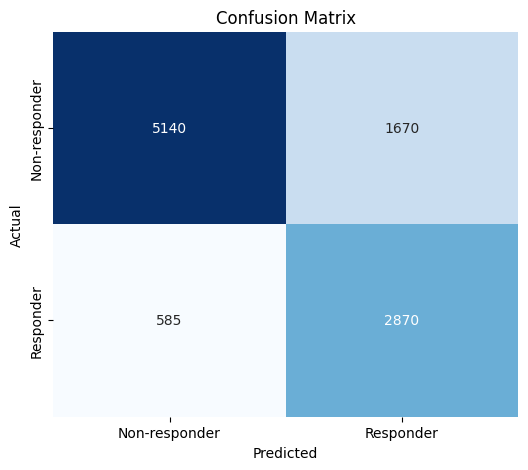

In [ ]:
#  3.2 Run hyperparameter tuning and evaluation for Logistic Regression (LR)

# Step 1: Compute class balance
w = class_balance(y_train)  
print(f"Class balance ratio: neg/pos = {w:.2f}")

# Step 2: Define and run Optuna study
name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study.best_value:.3f} | params={study.best_params}")


# Step 3: Refit model on the full training set by best parameters which obtains by Optuna
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )
model_lr.fit(X_train, y_train)

# Step 4: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred = model_lr.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

#  Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:53:49,246] A new study created in memory with name: no-name-13716b30-f6ed-4478-8c27-b280aefc3451



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:07<?, ?it/s]


Best trial: 0. Best value: 0.841583:   0%|          | 0/20 [00:07<?, ?it/s]


Best trial: 0. Best value: 0.841583:   5%|▌         | 1/20 [00:07<02:24,  7.62s/it]

[I 2025-10-16 23:53:56,867] Trial 0 finished with value: 0.8415834167426381 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8415834167426381.



Best trial: 0. Best value: 0.841583:   5%|▌         | 1/20 [00:09<02:24,  7.62s/it]


Best trial: 0. Best value: 0.841583:   5%|▌         | 1/20 [00:09<02:24,  7.62s/it]


Best trial: 0. Best value: 0.841583:  10%|█         | 2/20 [00:09<01:18,  4.34s/it]

[I 2025-10-16 23:53:58,907] Trial 1 finished with value: 0.8335654980863674 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8415834167426381.



Best trial: 0. Best value: 0.841583:  10%|█         | 2/20 [00:18<01:18,  4.34s/it]


Best trial: 2. Best value: 0.855378:  10%|█         | 2/20 [00:18<01:18,  4.34s/it]


Best trial: 2. Best value: 0.855378:  15%|█▌        | 3/20 [00:18<01:47,  6.31s/it]

[I 2025-10-16 23:54:07,569] Trial 2 finished with value: 0.8553778946216405 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8553778946216405.



Best trial: 2. Best value: 0.855378:  15%|█▌        | 3/20 [00:23<01:47,  6.31s/it]


Best trial: 2. Best value: 0.855378:  15%|█▌        | 3/20 [00:23<01:47,  6.31s/it]


Best trial: 2. Best value: 0.855378:  20%|██        | 4/20 [00:23<01:30,  5.68s/it]

[I 2025-10-16 23:54:12,277] Trial 3 finished with value: 0.8398699399240497 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8553778946216405.



Best trial: 2. Best value: 0.855378:  20%|██        | 4/20 [00:24<01:30,  5.68s/it]


Best trial: 2. Best value: 0.855378:  20%|██        | 4/20 [00:24<01:30,  5.68s/it]


Best trial: 2. Best value: 0.855378:  25%|██▌       | 5/20 [00:24<01:03,  4.26s/it]

[I 2025-10-16 23:54:14,015] Trial 4 finished with value: 0.8321568371191594 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8553778946216405.



Best trial: 2. Best value: 0.855378:  25%|██▌       | 5/20 [00:26<01:03,  4.26s/it]


Best trial: 2. Best value: 0.855378:  25%|██▌       | 5/20 [00:26<01:03,  4.26s/it]


Best trial: 2. Best value: 0.855378:  30%|███       | 6/20 [00:26<00:47,  3.41s/it]

[I 2025-10-16 23:54:15,783] Trial 5 finished with value: 0.8314189038423532 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8553778946216405.



Best trial: 2. Best value: 0.855378:  30%|███       | 6/20 [00:30<00:47,  3.41s/it]


Best trial: 2. Best value: 0.855378:  30%|███       | 6/20 [00:30<00:47,  3.41s/it]


Best trial: 2. Best value: 0.855378:  35%|███▌      | 7/20 [00:30<00:47,  3.65s/it]

[I 2025-10-16 23:54:19,933] Trial 6 finished with value: 0.8360172402251733 and parameters: {'n_estimators': 400, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8553778946216405.



Best trial: 2. Best value: 0.855378:  35%|███▌      | 7/20 [00:36<00:47,  3.65s/it]


Best trial: 7. Best value: 0.860009:  35%|███▌      | 7/20 [00:36<00:47,  3.65s/it]


Best trial: 7. Best value: 0.860009:  40%|████      | 8/20 [00:36<00:51,  4.26s/it]

[I 2025-10-16 23:54:25,488] Trial 7 finished with value: 0.8600090368934761 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8600090368934761.



Best trial: 7. Best value: 0.860009:  40%|████      | 8/20 [00:40<00:51,  4.26s/it]


Best trial: 7. Best value: 0.860009:  40%|████      | 8/20 [00:40<00:51,  4.26s/it]


Best trial: 7. Best value: 0.860009:  45%|████▌     | 9/20 [00:40<00:46,  4.26s/it]

[I 2025-10-16 23:54:29,744] Trial 8 finished with value: 0.8281809493147687 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8600090368934761.



Best trial: 7. Best value: 0.860009:  45%|████▌     | 9/20 [00:49<00:46,  4.26s/it]


Best trial: 7. Best value: 0.860009:  45%|████▌     | 9/20 [00:49<00:46,  4.26s/it]


Best trial: 7. Best value: 0.860009:  50%|█████     | 10/20 [00:49<00:56,  5.67s/it]

[I 2025-10-16 23:54:38,564] Trial 9 finished with value: 0.8379956212771292 and parameters: {'n_estimators': 800, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 7 with value: 0.8600090368934761.



Best trial: 7. Best value: 0.860009:  50%|█████     | 10/20 [01:13<00:56,  5.67s/it]


Best trial: 10. Best value: 0.864095:  50%|█████     | 10/20 [01:13<00:56,  5.67s/it]


Best trial: 10. Best value: 0.864095:  55%|█████▌    | 11/20 [01:13<01:41, 11.24s/it]

[I 2025-10-16 23:55:02,456] Trial 10 finished with value: 0.8640946982495734 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8640946982495734.



Best trial: 10. Best value: 0.864095:  55%|█████▌    | 11/20 [01:37<01:41, 11.24s/it]


Best trial: 10. Best value: 0.864095:  55%|█████▌    | 11/20 [01:37<01:41, 11.24s/it]


Best trial: 10. Best value: 0.864095:  60%|██████    | 12/20 [01:37<02:01, 15.20s/it]

[I 2025-10-16 23:55:26,705] Trial 11 finished with value: 0.8640946982495734 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8640946982495734.



Best trial: 10. Best value: 0.864095:  60%|██████    | 12/20 [02:01<02:01, 15.20s/it]


Best trial: 10. Best value: 0.864095:  60%|██████    | 12/20 [02:01<02:01, 15.20s/it]


Best trial: 10. Best value: 0.864095:  65%|██████▌   | 13/20 [02:01<02:05, 17.88s/it]

[I 2025-10-16 23:55:50,757] Trial 12 finished with value: 0.8640946982495734 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8640946982495734.



Best trial: 10. Best value: 0.864095:  65%|██████▌   | 13/20 [02:25<02:05, 17.88s/it]


Best trial: 10. Best value: 0.864095:  65%|██████▌   | 13/20 [02:25<02:05, 17.88s/it]


Best trial: 10. Best value: 0.864095:  70%|███████   | 14/20 [02:25<01:57, 19.64s/it]

[I 2025-10-16 23:56:14,457] Trial 13 finished with value: 0.8638584161582417 and parameters: {'n_estimators': 800, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8640946982495734.



Best trial: 10. Best value: 0.864095:  70%|███████   | 14/20 [02:44<01:57, 19.64s/it]


Best trial: 14. Best value: 0.864209:  70%|███████   | 14/20 [02:44<01:57, 19.64s/it]


Best trial: 14. Best value: 0.864209:  75%|███████▌  | 15/20 [02:44<01:37, 19.47s/it]

[I 2025-10-16 23:56:33,528] Trial 14 finished with value: 0.8642093860437638 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.



Best trial: 14. Best value: 0.864209:  75%|███████▌  | 15/20 [03:01<01:37, 19.47s/it]


Best trial: 14. Best value: 0.864209:  75%|███████▌  | 15/20 [03:01<01:37, 19.47s/it]


Best trial: 14. Best value: 0.864209:  80%|████████  | 16/20 [03:01<01:15, 18.80s/it]

[I 2025-10-16 23:56:50,761] Trial 15 finished with value: 0.8621482597737643 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.



Best trial: 14. Best value: 0.864209:  80%|████████  | 16/20 [03:20<01:15, 18.80s/it]


Best trial: 14. Best value: 0.864209:  80%|████████  | 16/20 [03:20<01:15, 18.80s/it]


Best trial: 14. Best value: 0.864209:  85%|████████▌ | 17/20 [03:20<00:56, 18.81s/it]

[I 2025-10-16 23:57:09,599] Trial 16 finished with value: 0.8642093860437638 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.



Best trial: 14. Best value: 0.864209:  85%|████████▌ | 17/20 [03:37<00:56, 18.81s/it]


Best trial: 14. Best value: 0.864209:  85%|████████▌ | 17/20 [03:37<00:56, 18.81s/it]


Best trial: 14. Best value: 0.864209:  90%|█████████ | 18/20 [03:37<00:36, 18.37s/it]

[I 2025-10-16 23:57:26,940] Trial 17 finished with value: 0.8611086982623238 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.



Best trial: 14. Best value: 0.864209:  90%|█████████ | 18/20 [03:54<00:36, 18.37s/it]


Best trial: 14. Best value: 0.864209:  90%|█████████ | 18/20 [03:54<00:36, 18.37s/it]


Best trial: 14. Best value: 0.864209:  95%|█████████▌| 19/20 [03:54<00:17, 17.96s/it]

[I 2025-10-16 23:57:43,958] Trial 18 finished with value: 0.8621482597737643 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.



Best trial: 14. Best value: 0.864209:  95%|█████████▌| 19/20 [04:05<00:17, 17.96s/it]


Best trial: 14. Best value: 0.864209:  95%|█████████▌| 19/20 [04:05<00:17, 17.96s/it]


Best trial: 14. Best value: 0.864209: 100%|██████████| 20/20 [04:05<00:00, 15.67s/it]


Best trial: 14. Best value: 0.864209: 100%|██████████| 20/20 [04:05<00:00, 12.25s/it]

[I 2025-10-16 23:57:54,278] Trial 19 finished with value: 0.8586288652509397 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8642093860437638.
✅ RF best AUC=0.864 | params={'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}



[Responder Class Metrics]
Accuracy     : 78.03
Precision    : 63.22
Recall       : 83.07
F1 Score     : 71.79
ROC AUC Score: 86.64

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.90      0.75      0.82      6810
    Responder       0.63      0.83      0.72      3455

     accuracy                           0.78     10265
    macro avg       0.76      0.79      0.77     10265
 weighted avg       0.81      0.78      0.79     10265



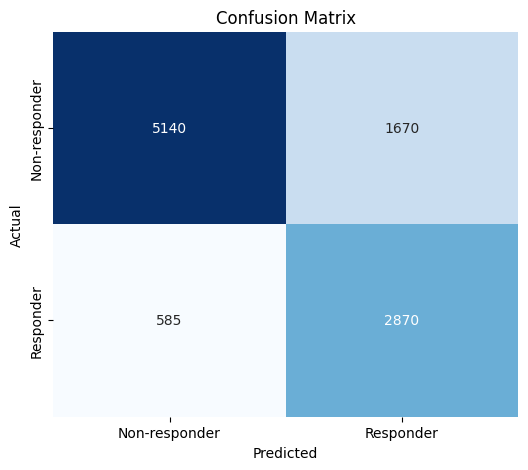

In [ ]:
#  3.3 Run hyperparameter tuning and evaluation for Random Forest (RF)

# Step 1: Define and run Optuna study
name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})
model_rf.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_rf = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_rf = model_lr.predict(X_test)   

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:58:13,019] A new study created in memory with name: no-name-e332d586-f6d1-4b0c-9c66-3186999b14d7



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:15<?, ?it/s]


Best trial: 0. Best value: 0.901955:   0%|          | 0/20 [00:15<?, ?it/s]


Best trial: 0. Best value: 0.901955:   5%|▌         | 1/20 [00:15<05:02, 15.90s/it]

[I 2025-10-16 23:58:28,919] Trial 0 finished with value: 0.9019548192515051 and parameters: {'learning_rate': 0.02734574918429525, 'max_depth': 5, 'subsample': 0.7174281595508009, 'colsample_bytree': 0.9686959846234784, 'n_estimators': 400}. Best is trial 0 with value: 0.9019548192515051.



Best trial: 0. Best value: 0.901955:   5%|▌         | 1/20 [01:14<05:02, 15.90s/it]


Best trial: 1. Best value: 0.909028:   5%|▌         | 1/20 [01:14<05:02, 15.90s/it]


Best trial: 1. Best value: 0.909028:  10%|█         | 2/20 [01:14<12:17, 40.95s/it]

[I 2025-10-16 23:59:27,401] Trial 1 finished with value: 0.9090276095424497 and parameters: {'learning_rate': 0.05672882440021502, 'max_depth': 10, 'subsample': 0.8138633801170782, 'colsample_bytree': 0.8426993872349902, 'n_estimators': 600}. Best is trial 1 with value: 0.9090276095424497.



Best trial: 1. Best value: 0.909028:  10%|█         | 2/20 [01:21<12:17, 40.95s/it]


Best trial: 1. Best value: 0.909028:  10%|█         | 2/20 [01:21<12:17, 40.95s/it]


Best trial: 1. Best value: 0.909028:  15%|█▌        | 3/20 [01:21<07:16, 25.65s/it]

[I 2025-10-16 23:59:34,847] Trial 2 finished with value: 0.9068129463991619 and parameters: {'learning_rate': 0.183871876610725, 'max_depth': 5, 'subsample': 0.8577892581368849, 'colsample_bytree': 0.9140041961330482, 'n_estimators': 200}. Best is trial 1 with value: 0.9090276095424497.



Best trial: 1. Best value: 0.909028:  15%|█▌        | 3/20 [02:24<07:16, 25.65s/it]


Best trial: 1. Best value: 0.909028:  15%|█▌        | 3/20 [02:24<07:16, 25.65s/it]


Best trial: 1. Best value: 0.909028:  20%|██        | 4/20 [02:24<10:41, 40.11s/it]

[I 2025-10-17 00:00:37,118] Trial 3 finished with value: 0.9042630854323789 and parameters: {'learning_rate': 0.24889768431205964, 'max_depth': 10, 'subsample': 0.8865311605877431, 'colsample_bytree': 0.7412366050721823, 'n_estimators': 800}. Best is trial 1 with value: 0.9090276095424497.



Best trial: 1. Best value: 0.909028:  20%|██        | 4/20 [03:03<10:41, 40.11s/it]


Best trial: 1. Best value: 0.909028:  20%|██        | 4/20 [03:03<10:41, 40.11s/it]


Best trial: 1. Best value: 0.909028:  25%|██▌       | 5/20 [03:03<09:55, 39.72s/it]

[I 2025-10-17 00:01:16,141] Trial 4 finished with value: 0.9064643008175174 and parameters: {'learning_rate': 0.12485944841411326, 'max_depth': 10, 'subsample': 0.7623329692911361, 'colsample_bytree': 0.9233997662064547, 'n_estimators': 400}. Best is trial 1 with value: 0.9090276095424497.



Best trial: 1. Best value: 0.909028:  25%|██▌       | 5/20 [03:30<09:55, 39.72s/it]


Best trial: 5. Best value: 0.909676:  25%|██▌       | 5/20 [03:30<09:55, 39.72s/it]


Best trial: 5. Best value: 0.909676:  30%|███       | 6/20 [03:30<08:18, 35.61s/it]

[I 2025-10-17 00:01:43,796] Trial 5 finished with value: 0.9096762563460137 and parameters: {'learning_rate': 0.046092447474446144, 'max_depth': 4, 'subsample': 0.9532872146036371, 'colsample_bytree': 0.7131793165311264, 'n_estimators': 1000}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  30%|███       | 6/20 [03:43<08:18, 35.61s/it]


Best trial: 5. Best value: 0.909676:  30%|███       | 6/20 [03:43<08:18, 35.61s/it]


Best trial: 5. Best value: 0.909676:  35%|███▌      | 7/20 [03:43<06:04, 28.02s/it]

[I 2025-10-17 00:01:56,178] Trial 6 finished with value: 0.8999304833914541 and parameters: {'learning_rate': 0.03748077798337463, 'max_depth': 4, 'subsample': 0.9873219040950709, 'colsample_bytree': 0.6540683519162354, 'n_estimators': 400}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  35%|███▌      | 7/20 [04:09<06:04, 28.02s/it]


Best trial: 5. Best value: 0.909676:  35%|███▌      | 7/20 [04:09<06:04, 28.02s/it]


Best trial: 5. Best value: 0.909676:  40%|████      | 8/20 [04:09<05:29, 27.45s/it]

[I 2025-10-17 00:02:22,408] Trial 7 finished with value: 0.8942168795994654 and parameters: {'learning_rate': 0.011084953660255045, 'max_depth': 4, 'subsample': 0.692245993236302, 'colsample_bytree': 0.9106649133671669, 'n_estimators': 800}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  40%|████      | 8/20 [05:08<05:29, 27.45s/it]


Best trial: 5. Best value: 0.909676:  40%|████      | 8/20 [05:08<05:29, 27.45s/it]


Best trial: 5. Best value: 0.909676:  45%|████▌     | 9/20 [05:08<06:50, 37.34s/it]

[I 2025-10-17 00:03:21,498] Trial 8 finished with value: 0.9090024406518888 and parameters: {'learning_rate': 0.07410895687701172, 'max_depth': 10, 'subsample': 0.9872103654598892, 'colsample_bytree': 0.9540510426346207, 'n_estimators': 600}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  45%|████▌     | 9/20 [07:04<06:50, 37.34s/it]


Best trial: 5. Best value: 0.909676:  45%|████▌     | 9/20 [07:04<06:50, 37.34s/it]


Best trial: 5. Best value: 0.909676:  50%|█████     | 10/20 [07:04<10:15, 61.57s/it]

[I 2025-10-17 00:05:17,314] Trial 9 finished with value: 0.9088193519150138 and parameters: {'learning_rate': 0.019511360626543104, 'max_depth': 11, 'subsample': 0.7678277033987008, 'colsample_bytree': 0.623656183119659, 'n_estimators': 1000}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  50%|█████     | 10/20 [08:00<10:15, 61.57s/it]


Best trial: 5. Best value: 0.909676:  50%|█████     | 10/20 [08:00<10:15, 61.57s/it]


Best trial: 5. Best value: 0.909676:  55%|█████▌    | 11/20 [08:00<08:59, 59.90s/it]

[I 2025-10-17 00:06:13,418] Trial 10 finished with value: 0.9043347736048333 and parameters: {'learning_rate': 0.08210525214822297, 'max_depth': 7, 'subsample': 0.6365180252414533, 'colsample_bytree': 0.7251828207382728, 'n_estimators': 1000}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  55%|█████▌    | 11/20 [08:53<08:59, 59.90s/it]


Best trial: 5. Best value: 0.909676:  55%|█████▌    | 11/20 [08:53<08:59, 59.90s/it]


Best trial: 5. Best value: 0.909676:  60%|██████    | 12/20 [08:53<07:42, 57.80s/it]

[I 2025-10-17 00:07:06,412] Trial 11 finished with value: 0.9092804938043355 and parameters: {'learning_rate': 0.04657212841176649, 'max_depth': 8, 'subsample': 0.8861745345162307, 'colsample_bytree': 0.8032390972356523, 'n_estimators': 800}. Best is trial 5 with value: 0.9096762563460137.



Best trial: 5. Best value: 0.909676:  60%|██████    | 12/20 [09:35<07:42, 57.80s/it]


Best trial: 12. Best value: 0.911497:  60%|██████    | 12/20 [09:35<07:42, 57.80s/it]


Best trial: 12. Best value: 0.911497:  65%|██████▌   | 13/20 [09:35<06:10, 52.97s/it]

[I 2025-10-17 00:07:48,273] Trial 12 finished with value: 0.9114965847342908 and parameters: {'learning_rate': 0.03972163070026863, 'max_depth': 7, 'subsample': 0.9258406760470758, 'colsample_bytree': 0.8010367061000364, 'n_estimators': 800}. Best is trial 12 with value: 0.9114965847342908.



Best trial: 12. Best value: 0.911497:  65%|██████▌   | 13/20 [10:28<06:10, 52.97s/it]


Best trial: 12. Best value: 0.911497:  65%|██████▌   | 13/20 [10:28<06:10, 52.97s/it]


Best trial: 12. Best value: 0.911497:  70%|███████   | 14/20 [10:28<05:17, 52.93s/it]

[I 2025-10-17 00:08:41,119] Trial 13 finished with value: 0.9103986167868398 and parameters: {'learning_rate': 0.022644944365961924, 'max_depth': 7, 'subsample': 0.9493553156645426, 'colsample_bytree': 0.732871333063199, 'n_estimators': 1000}. Best is trial 12 with value: 0.9114965847342908.



Best trial: 12. Best value: 0.911497:  70%|███████   | 14/20 [11:13<05:17, 52.93s/it]


Best trial: 12. Best value: 0.911497:  70%|███████   | 14/20 [11:13<05:17, 52.93s/it]


Best trial: 12. Best value: 0.911497:  75%|███████▌  | 15/20 [11:13<04:13, 50.72s/it]

[I 2025-10-17 00:09:26,707] Trial 14 finished with value: 0.9084851170174107 and parameters: {'learning_rate': 0.017310324775018957, 'max_depth': 7, 'subsample': 0.9321913573664661, 'colsample_bytree': 0.8365187727652433, 'n_estimators': 800}. Best is trial 12 with value: 0.9114965847342908.



Best trial: 12. Best value: 0.911497:  75%|███████▌  | 15/20 [12:18<04:13, 50.72s/it]


Best trial: 15. Best value: 0.911751:  75%|███████▌  | 15/20 [12:18<04:13, 50.72s/it]


Best trial: 15. Best value: 0.911751:  80%|████████  | 16/20 [12:18<03:40, 55.02s/it]

[I 2025-10-17 00:10:31,728] Trial 15 finished with value: 0.9117513616436201 and parameters: {'learning_rate': 0.027269624936440234, 'max_depth': 8, 'subsample': 0.9208789645556855, 'colsample_bytree': 0.7768672342803322, 'n_estimators': 1000}. Best is trial 15 with value: 0.9117513616436201.



Best trial: 15. Best value: 0.911751:  80%|████████  | 16/20 [13:20<03:40, 55.02s/it]


Best trial: 15. Best value: 0.911751:  80%|████████  | 16/20 [13:20<03:40, 55.02s/it]


Best trial: 15. Best value: 0.911751:  85%|████████▌ | 17/20 [13:20<02:50, 56.93s/it]

[I 2025-10-17 00:11:33,078] Trial 16 finished with value: 0.9059802811371716 and parameters: {'learning_rate': 0.010003935844968706, 'max_depth': 8, 'subsample': 0.8243510761065526, 'colsample_bytree': 0.7859606726076698, 'n_estimators': 800}. Best is trial 15 with value: 0.9117513616436201.



Best trial: 15. Best value: 0.911751:  85%|████████▌ | 17/20 [14:24<02:50, 56.93s/it]


Best trial: 15. Best value: 0.911751:  85%|████████▌ | 17/20 [14:24<02:50, 56.93s/it]


Best trial: 15. Best value: 0.911751:  90%|█████████ | 18/20 [14:24<01:58, 59.30s/it]

[I 2025-10-17 00:12:37,892] Trial 17 finished with value: 0.9111189185585171 and parameters: {'learning_rate': 0.030421282986536353, 'max_depth': 8, 'subsample': 0.9152182121318784, 'colsample_bytree': 0.868584673033935, 'n_estimators': 1000}. Best is trial 15 with value: 0.9117513616436201.



Best trial: 15. Best value: 0.911751:  90%|█████████ | 18/20 [14:55<01:58, 59.30s/it]


Best trial: 15. Best value: 0.911751:  90%|█████████ | 18/20 [14:55<01:58, 59.30s/it]


Best trial: 15. Best value: 0.911751:  95%|█████████▌| 19/20 [14:55<00:50, 50.57s/it]

[I 2025-10-17 00:13:08,133] Trial 18 finished with value: 0.9026019054510371 and parameters: {'learning_rate': 0.015251640665680903, 'max_depth': 6, 'subsample': 0.8707454890453974, 'colsample_bytree': 0.7857908822333306, 'n_estimators': 600}. Best is trial 15 with value: 0.9117513616436201.



Best trial: 15. Best value: 0.911751:  95%|█████████▌| 19/20 [16:05<00:50, 50.57s/it]


Best trial: 15. Best value: 0.911751:  95%|█████████▌| 19/20 [16:05<00:50, 50.57s/it]


Best trial: 15. Best value: 0.911751: 100%|██████████| 20/20 [16:05<00:00, 56.65s/it]


Best trial: 15. Best value: 0.911751: 100%|██████████| 20/20 [16:05<00:00, 48.30s/it]

[I 2025-10-17 00:14:18,965] Trial 19 finished with value: 0.9076839958794741 and parameters: {'learning_rate': 0.08601860956681999, 'max_depth': 12, 'subsample': 0.8477603763556827, 'colsample_bytree': 0.6778456061167091, 'n_estimators': 600}. Best is trial 15 with value: 0.9117513616436201.
✅ GB best AUC=0.912 | params={'learning_rate': 0.027269624936440234, 'max_depth': 8, 'subsample': 0.9208789645556855, 'colsample_bytree': 0.7768672342803322, 'n_estimators': 1000}



[Responder Class Metrics]
Accuracy     : 83.54
Precision    : 72.70
Recall       : 81.79
F1 Score     : 76.98
ROC AUC Score: 91.46

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.90      0.84      0.87      6810
    Responder       0.73      0.82      0.77      3455

     accuracy                           0.84     10265
    macro avg       0.81      0.83      0.82     10265
 weighted avg       0.84      0.84      0.84     10265



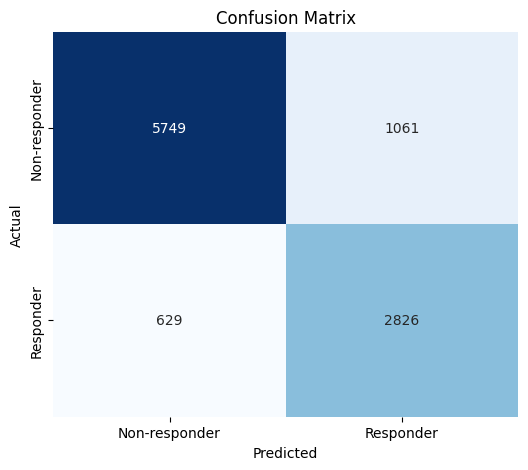

In [ ]:
#  3.4 Run hyperparameter tuning and evaluation for XGBoost (XGB)

# Step 1: Define and run Optuna study
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)
model_gb.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_gb = model_gb.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-17 00:15:25,244] A new study created in memory with name: no-name-8c234ac3-202c-4d52-a0ad-1fe5c37b9754



  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-17 00:15:25.252325: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step


 69/257 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


130/257 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


184/257 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step


243/257 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



  0%|          | 0/20 [00:38<?, ?it/s]


Best trial: 0. Best value: 0.889682:   0%|          | 0/20 [00:38<?, ?it/s]


Best trial: 0. Best value: 0.889682:   5%|▌         | 1/20 [00:38<12:05, 38.19s/it]

[I 2025-10-17 00:16:03,430] Trial 0 finished with value: 0.8896824615732801 and parameters: {'lr': 0.00028974005733691037, 'dropout': 0.3200964273868872, 'n1': 128, 'n2': 32}. Best is trial 0 with value: 0.8896824615732801.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step


 71/257 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


132/257 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


192/257 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


250/257 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step



Best trial: 0. Best value: 0.889682:   5%|▌         | 1/20 [01:09<12:05, 38.19s/it]


Best trial: 1. Best value: 0.892867:   5%|▌         | 1/20 [01:09<12:05, 38.19s/it]


Best trial: 1. Best value: 0.892867:  10%|█         | 2/20 [01:09<10:12, 34.02s/it]

[I 2025-10-17 00:16:34,527] Trial 1 finished with value: 0.8928668242943147 and parameters: {'lr': 0.0004942423642753127, 'dropout': 0.35435369849229487, 'n1': 64, 'n2': 16}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


 64/257 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


136/257 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


208/257 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step



Best trial: 1. Best value: 0.892867:  10%|█         | 2/20 [01:34<10:12, 34.02s/it]


Best trial: 1. Best value: 0.892867:  10%|█         | 2/20 [01:34<10:12, 34.02s/it]


Best trial: 1. Best value: 0.892867:  15%|█▌        | 3/20 [01:34<08:28, 29.91s/it]

[I 2025-10-17 00:16:59,561] Trial 2 finished with value: 0.889334812121869 and parameters: {'lr': 0.001256264129370236, 'dropout': 0.5363781143728116, 'n1': 64, 'n2': 48}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step


 65/257 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


131/257 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


201/257 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step



Best trial: 1. Best value: 0.892867:  15%|█▌        | 3/20 [02:07<08:28, 29.91s/it]


Best trial: 1. Best value: 0.892867:  15%|█▌        | 3/20 [02:07<08:28, 29.91s/it]


Best trial: 1. Best value: 0.892867:  20%|██        | 4/20 [02:07<08:17, 31.08s/it]

[I 2025-10-17 00:17:32,423] Trial 3 finished with value: 0.8866758416902019 and parameters: {'lr': 0.005749469158431576, 'dropout': 0.39700120970621466, 'n1': 32, 'n2': 48}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step


 59/257 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


122/257 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


189/257 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


245/257 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 1. Best value: 0.892867:  20%|██        | 4/20 [02:39<08:17, 31.08s/it]


Best trial: 1. Best value: 0.892867:  20%|██        | 4/20 [02:39<08:17, 31.08s/it]


Best trial: 1. Best value: 0.892867:  25%|██▌       | 5/20 [02:39<07:54, 31.63s/it]

[I 2025-10-17 00:18:05,024] Trial 4 finished with value: 0.8898908852224212 and parameters: {'lr': 0.004230780408173691, 'dropout': 0.33987854403252593, 'n1': 64, 'n2': 64}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step


 66/257 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


127/257 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


186/257 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step


248/257 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step



Best trial: 1. Best value: 0.892867:  25%|██▌       | 5/20 [03:31<07:54, 31.63s/it]


Best trial: 1. Best value: 0.892867:  25%|██▌       | 5/20 [03:31<07:54, 31.63s/it]


Best trial: 1. Best value: 0.892867:  30%|███       | 6/20 [03:31<08:58, 38.47s/it]

[I 2025-10-17 00:18:56,769] Trial 5 finished with value: 0.891474931519367 and parameters: {'lr': 0.00013736799102073076, 'dropout': 0.49638055619266597, 'n1': 64, 'n2': 64}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 64/257 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


128/257 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


187/257 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


249/257 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 1. Best value: 0.892867:  30%|███       | 6/20 [03:56<08:58, 38.47s/it]


Best trial: 1. Best value: 0.892867:  30%|███       | 6/20 [03:56<08:58, 38.47s/it]


Best trial: 1. Best value: 0.892867:  35%|███▌      | 7/20 [03:56<07:20, 33.91s/it]

[I 2025-10-17 00:19:21,307] Trial 6 finished with value: 0.8898519697346416 and parameters: {'lr': 0.0006819004369382589, 'dropout': 0.4694447656665378, 'n1': 64, 'n2': 32}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 64/257 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


127/257 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


191/257 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


250/257 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step



Best trial: 1. Best value: 0.892867:  35%|███▌      | 7/20 [04:10<07:20, 33.91s/it]


Best trial: 1. Best value: 0.892867:  35%|███▌      | 7/20 [04:10<07:20, 33.91s/it]


Best trial: 1. Best value: 0.892867:  40%|████      | 8/20 [04:10<05:32, 27.68s/it]

[I 2025-10-17 00:19:35,639] Trial 7 finished with value: 0.8816297447675271 and parameters: {'lr': 0.0019031883135801372, 'dropout': 0.31568129331974326, 'n1': 32, 'n2': 16}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


 59/257 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


113/257 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


174/257 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


234/257 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 1. Best value: 0.892867:  40%|████      | 8/20 [05:11<05:32, 27.68s/it]


Best trial: 1. Best value: 0.892867:  40%|████      | 8/20 [05:11<05:32, 27.68s/it]


Best trial: 1. Best value: 0.892867:  45%|████▌     | 9/20 [05:11<06:58, 38.04s/it]

[I 2025-10-17 00:20:36,446] Trial 8 finished with value: 0.8916212962549753 and parameters: {'lr': 0.00019079269669101378, 'dropout': 0.5788754445196672, 'n1': 96, 'n2': 48}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step


 60/257 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


121/257 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


187/257 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


248/257 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step



Best trial: 1. Best value: 0.892867:  45%|████▌     | 9/20 [05:45<06:58, 38.04s/it]


Best trial: 1. Best value: 0.892867:  45%|████▌     | 9/20 [05:45<06:58, 38.04s/it]


Best trial: 1. Best value: 0.892867:  50%|█████     | 10/20 [05:45<06:10, 37.03s/it]

[I 2025-10-17 00:21:11,239] Trial 9 finished with value: 0.8814166061019485 and parameters: {'lr': 0.006091807677531964, 'dropout': 0.5613954793870739, 'n1': 64, 'n2': 64}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step


 57/257 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


121/257 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


177/257 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


238/257 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



Best trial: 1. Best value: 0.892867:  50%|█████     | 10/20 [06:13<06:10, 37.03s/it]


Best trial: 1. Best value: 0.892867:  50%|█████     | 10/20 [06:13<06:10, 37.03s/it]


Best trial: 1. Best value: 0.892867:  55%|█████▌    | 11/20 [06:13<05:06, 34.00s/it]

[I 2025-10-17 00:21:38,366] Trial 10 finished with value: 0.8882928266935275 and parameters: {'lr': 0.00045659111813092275, 'dropout': 0.2060198078901981, 'n1': 128, 'n2': 16}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step


 69/257 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


132/257 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


193/257 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


249/257 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 1. Best value: 0.892867:  55%|█████▌    | 11/20 [07:06<05:06, 34.00s/it]


Best trial: 1. Best value: 0.892867:  55%|█████▌    | 11/20 [07:06<05:06, 34.00s/it]


Best trial: 1. Best value: 0.892867:  60%|██████    | 12/20 [07:06<05:18, 39.87s/it]

[I 2025-10-17 00:22:31,661] Trial 11 finished with value: 0.8880205510964339 and parameters: {'lr': 0.00011444477752455198, 'dropout': 0.43053077732315875, 'n1': 96, 'n2': 32}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step


 55/257 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


118/257 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


176/257 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


235/257 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 1. Best value: 0.892867:  60%|██████    | 12/20 [07:41<05:18, 39.87s/it]


Best trial: 1. Best value: 0.892867:  60%|██████    | 12/20 [07:41<05:18, 39.87s/it]


Best trial: 1. Best value: 0.892867:  65%|██████▌   | 13/20 [07:41<04:29, 38.52s/it]

[I 2025-10-17 00:23:07,083] Trial 12 finished with value: 0.885467934169339 and parameters: {'lr': 0.00024592794095484627, 'dropout': 0.2396703796649336, 'n1': 96, 'n2': 48}. Best is trial 1 with value: 0.8928668242943147.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step


 56/257 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


107/257 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


158/257 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


210/257 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



Best trial: 1. Best value: 0.892867:  65%|██████▌   | 13/20 [08:29<04:29, 38.52s/it]


Best trial: 1. Best value: 0.892867:  65%|██████▌   | 13/20 [08:29<04:29, 38.52s/it]

[I 2025-10-17 00:23:54,829] Trial 13 finished with value: 0.892760869241836 and parameters: {'lr': 0.0002754859999667696, 'dropout': 0.38831574257412305, 'n1': 96, 'n2': 16}. Best is trial 1 with value: 0.8928668242943147.



Best trial: 1. Best value: 0.892867:  70%|███████   | 14/20 [08:29<04:07, 41.31s/it]


  1/257 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step


 75/257 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


141/257 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


208/257 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step



Best trial: 1. Best value: 0.892867:  70%|███████   | 14/20 [09:06<04:07, 41.31s/it]


Best trial: 14. Best value: 0.893556:  70%|███████   | 14/20 [09:06<04:07, 41.31s/it]


Best trial: 14. Best value: 0.893556:  75%|███████▌  | 15/20 [09:06<03:20, 40.02s/it]

[I 2025-10-17 00:24:31,869] Trial 14 finished with value: 0.8935564784591485 and parameters: {'lr': 0.000439372924528659, 'dropout': 0.37987385799648365, 'n1': 96, 'n2': 16}. Best is trial 14 with value: 0.8935564784591485.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step


 58/257 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


118/257 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


179/257 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


239/257 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step



Best trial: 14. Best value: 0.893556:  75%|███████▌  | 15/20 [09:29<03:20, 40.02s/it]


Best trial: 14. Best value: 0.893556:  75%|███████▌  | 15/20 [09:29<03:20, 40.02s/it]


Best trial: 14. Best value: 0.893556:  80%|████████  | 16/20 [09:29<02:19, 34.88s/it]

[I 2025-10-17 00:24:54,793] Trial 15 finished with value: 0.885789949869414 and parameters: {'lr': 0.0006336953630314293, 'dropout': 0.27834685885743793, 'n1': 128, 'n2': 16}. Best is trial 14 with value: 0.8935564784591485.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


 61/257 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


135/257 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


211/257 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step



Best trial: 14. Best value: 0.893556:  80%|████████  | 16/20 [10:17<02:19, 34.88s/it]


Best trial: 16. Best value: 0.894861:  80%|████████  | 16/20 [10:17<02:19, 34.88s/it]


Best trial: 16. Best value: 0.894861:  85%|████████▌ | 17/20 [10:17<01:56, 38.72s/it]

[I 2025-10-17 00:25:42,445] Trial 16 finished with value: 0.894860811386592 and parameters: {'lr': 0.001860501594855373, 'dropout': 0.378890898342751, 'n1': 32, 'n2': 32}. Best is trial 16 with value: 0.894860811386592.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


 61/257 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


121/257 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


184/257 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


251/257 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 16. Best value: 0.894861:  85%|████████▌ | 17/20 [10:59<01:56, 38.72s/it]

[I 2025-10-17 00:26:24,542] Trial 17 finished with value: 0.8894020509126148 and parameters: {'lr': 0.00245093771409559, 'dropout': 0.42258899362237345, 'n1': 32, 'n2': 32}. Best is trial 16 with value: 0.894860811386592.



Best trial: 16. Best value: 0.894861:  85%|████████▌ | 17/20 [10:59<01:56, 38.72s/it]


Best trial: 16. Best value: 0.894861:  90%|█████████ | 18/20 [10:59<01:19, 39.73s/it]


  1/257 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step


 58/257 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


127/257 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


203/257 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step



Best trial: 16. Best value: 0.894861:  90%|█████████ | 18/20 [11:35<01:19, 39.73s/it]


Best trial: 16. Best value: 0.894861:  90%|█████████ | 18/20 [11:35<01:19, 39.73s/it]


Best trial: 16. Best value: 0.894861:  95%|█████████▌| 19/20 [11:35<00:38, 38.53s/it]

[I 2025-10-17 00:27:00,273] Trial 18 finished with value: 0.8904242465536549 and parameters: {'lr': 0.001079650422297323, 'dropout': 0.4498976038465664, 'n1': 32, 'n2': 32}. Best is trial 16 with value: 0.894860811386592.



  1/257 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step


 63/257 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


123/257 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


174/257 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


230/257 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



Best trial: 16. Best value: 0.894861:  95%|█████████▌| 19/20 [12:09<00:38, 38.53s/it]


Best trial: 16. Best value: 0.894861:  95%|█████████▌| 19/20 [12:09<00:38, 38.53s/it]


Best trial: 16. Best value: 0.894861: 100%|██████████| 20/20 [12:09<00:00, 37.44s/it]


Best trial: 16. Best value: 0.894861: 100%|██████████| 20/20 [12:09<00:00, 36.50s/it]

[I 2025-10-17 00:27:35,158] Trial 19 finished with value: 0.8918173346848828 and parameters: {'lr': 0.0027359312719360458, 'dropout': 0.37759729550637783, 'n1': 96, 'n2': 16}. Best is trial 16 with value: 0.894860811386592.
✅ ANN best AUC=0.895 | params={'lr': 0.001860501594855373, 'dropout': 0.378890898342751, 'n1': 32, 'n2': 32}



  1/321 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


 65/321 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


140/321 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


209/321 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


276/321 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step



[Responder Class Metrics]
Accuracy     : 79.86
Precision    : 65.20
Recall       : 86.16
F1 Score     : 74.23
ROC AUC Score: 88.88

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.92      0.77      0.83      6810
    Responder       0.65      0.86      0.74      3455

     accuracy                           0.80     10265
    macro avg       0.78      0.81      0.79     10265
 weighted avg       0.83      0.80      0.80     10265



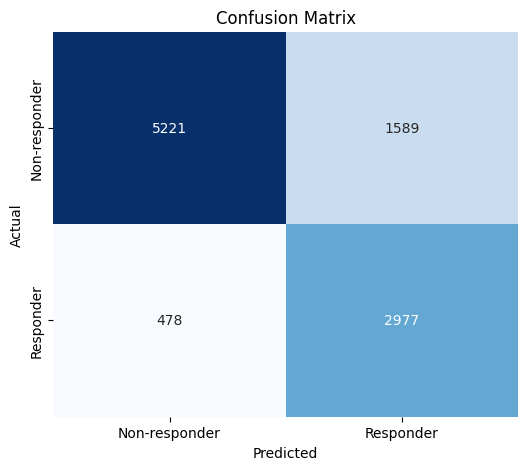

In [ ]:
#  3.5 Run hyperparameter tuning and evaluation for ANN 

# Step 1: Define and run Optuna study
name = 'ANN'
study_ann = optuna.create_study(direction="maximize") 
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"✅ {name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna

# Retrieve best hyperparameters from the ANN Optuna study
best_params = study_ann.best_params

# Compute class imbalance ratio for weighting
w = class_balance(y_train)

#  Build ANN architecture
ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Handle class imbalance via per-sample weighting
sample_weights = np.where(y_train == 1, w, 1)

# Train model
ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# Step 3: Evaluate on test data

# Probability predictions for ROC/AUC
y_prob_ann = ann.predict(X_test)
# Binary predictions using default 0.5 threshold
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


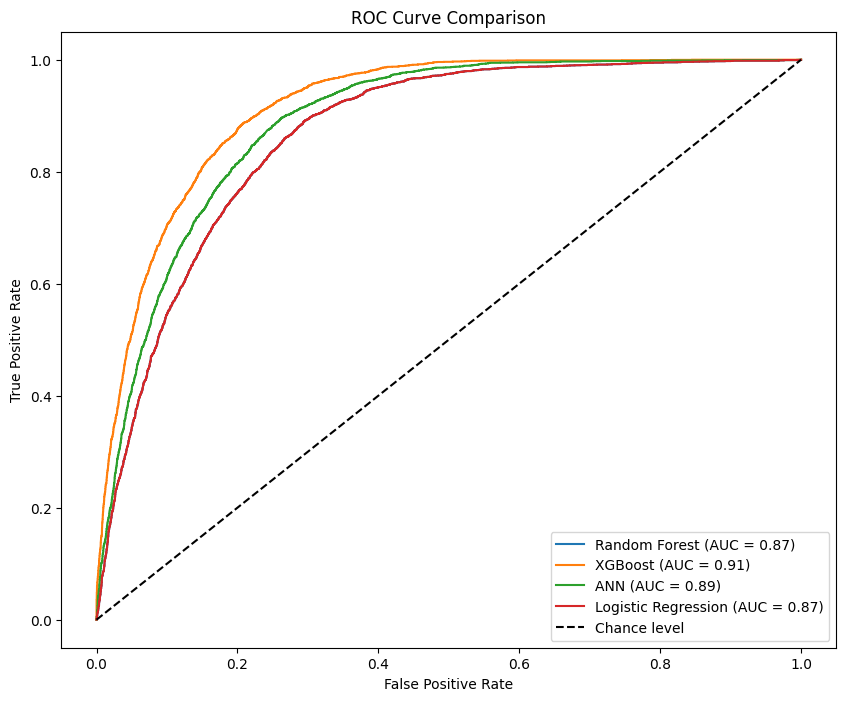

In [ ]:
# Model Comparsion - ROC Curve

# Compute ROC and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

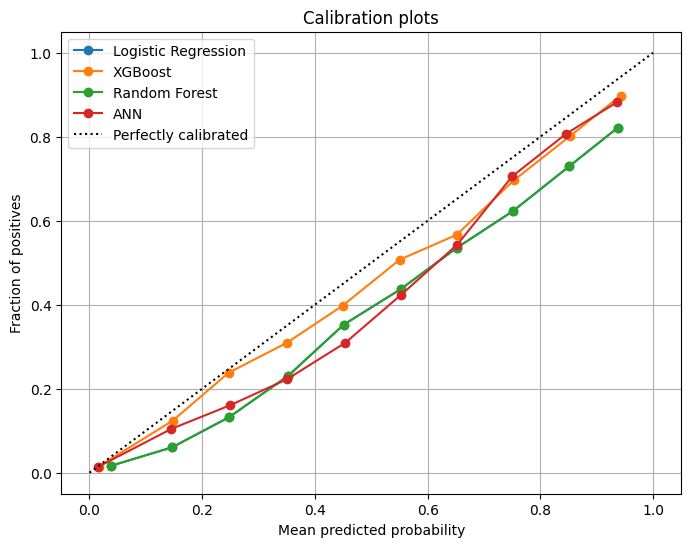

In [ ]:
# Calibration Curver Comparison

# Initialize plot
plt.figure(figsize=(8, 6))

# Define models and their predicted probabilities
for model_name, y_prob in [
    ('Logistic Regression', y_prob),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation using Matthews Correlation Coefficient (MCC)

# Define threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary classes
y_pred_logreg = (y_prob > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Compute MCC for each model
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.5975
MCC - XGBoost: 0.6451
MCC - Random Forest: 0.5570
MCC - ANN: 0.5975


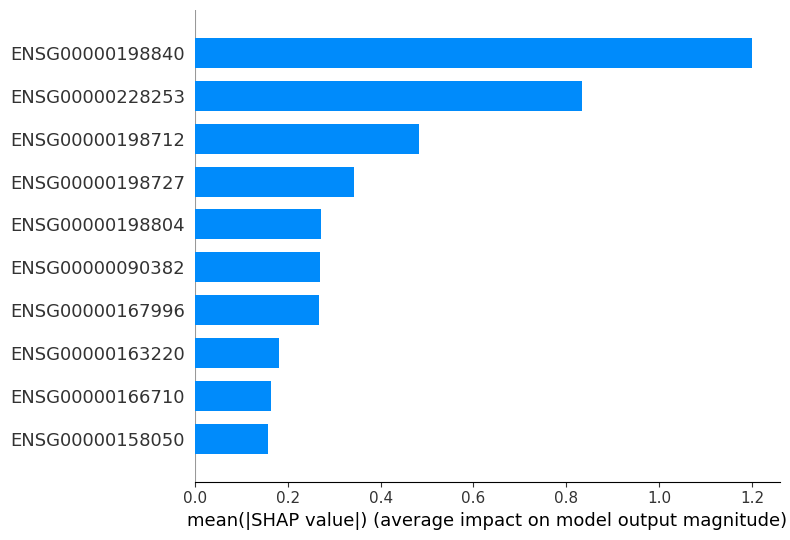

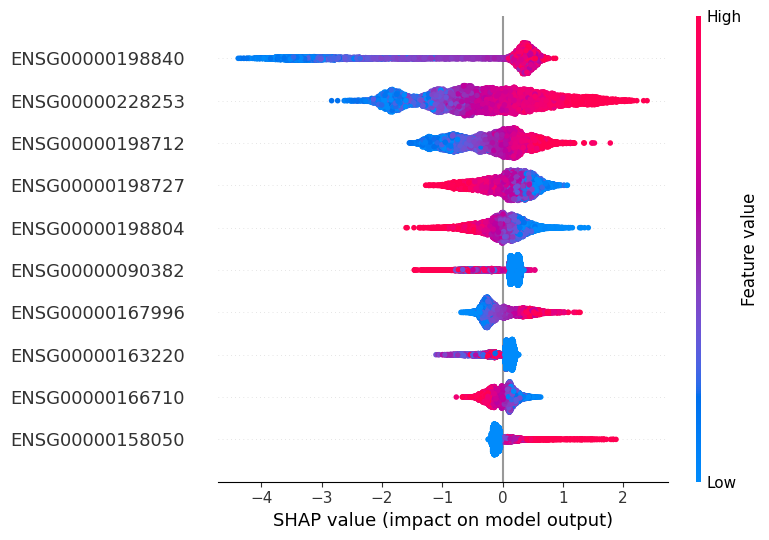

In [ ]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# 4.1 SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)


🔹 SHAP Modality Contribution (%) by Top-N Features:
Modality   Fluxomic  Transcriptomic
Top_N                              
50         3.510000       96.489998
100        9.610000       90.389999
150       13.930000       86.070000
200       16.270000       83.730003
250       16.990000       83.010002
300       17.299999       82.699997
350       17.360001       82.639999
400       17.360001       82.639999
450       17.360001       82.639999


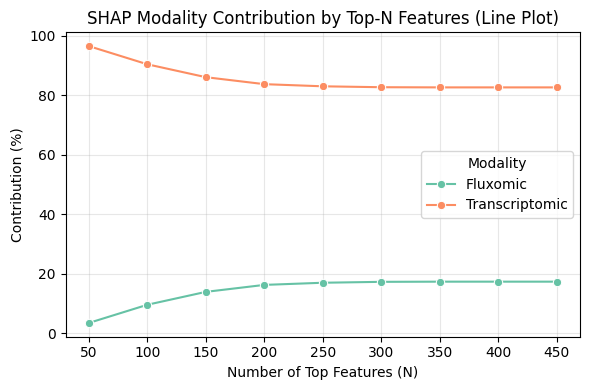

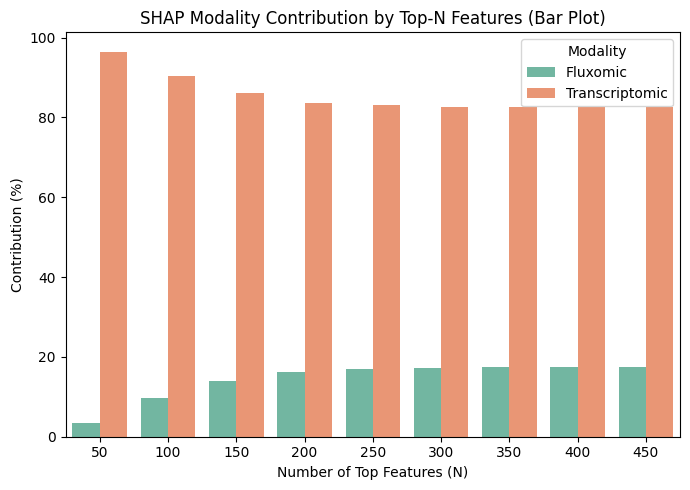

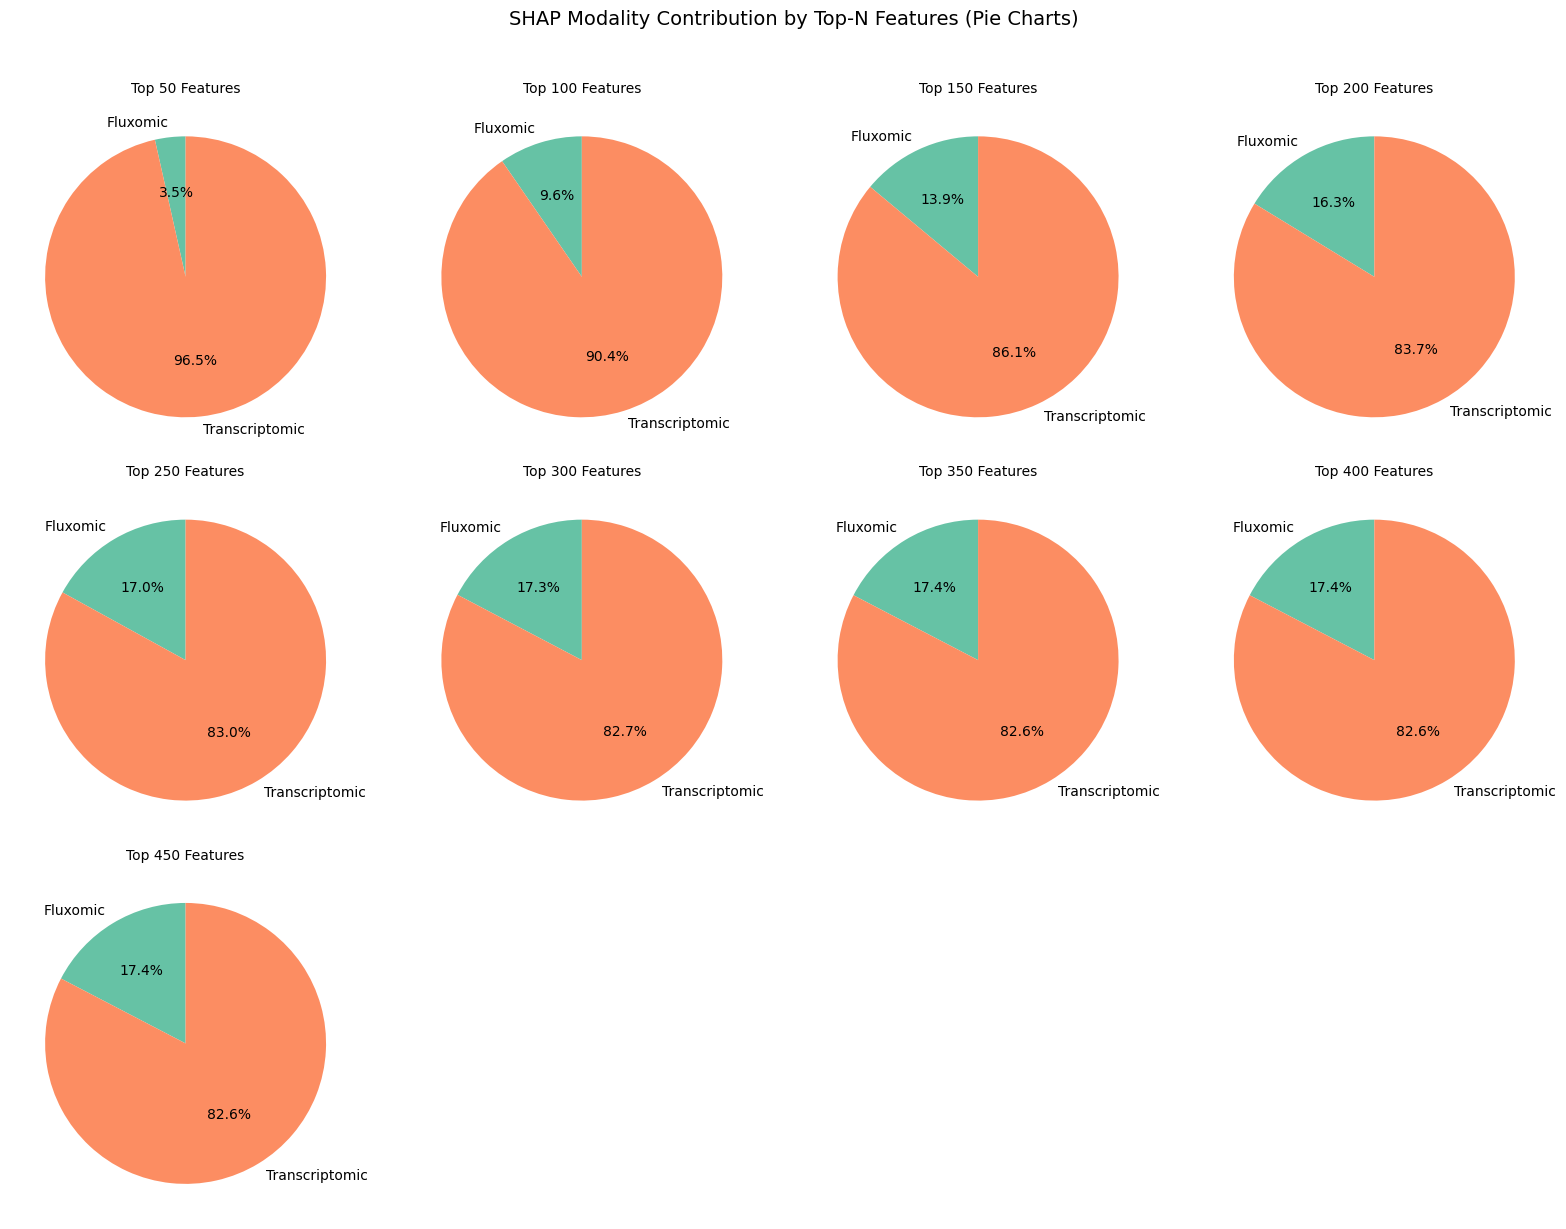

In [18]:
# 4.2 SHAP Modality Contribution for Top-N Features

# Create a DataFrame of mean absolute SHAP values
shap_df = pd.DataFrame({
    "Feature": X.columns,
    "MeanAbsSHAP": np.abs(shap_values).mean(axis=0)
})

# Assign modality for each feature
shap_df["Modality"] = shap_df["Feature"].apply(
    lambda f: "Fluxomic" if f in X_flux.columns else "Transcriptomic"
)

# Define list of top-N values to analyze
top_n_list = [50, 100, 150, 200, 250, 300, 350, 400, 450]

# Store modality contributions for each N
modality_contribs = []

for n in top_n_list:
    # Select top-N features by SHAP value
    top_features = shap_df.nlargest(n, "MeanAbsSHAP")

    # Compute contribution per modality
    contrib = top_features.groupby("Modality")["MeanAbsSHAP"].sum()
    perc = 100 * contrib / contrib.sum()

    # Store results in a DataFrame-friendly format
    for modality in perc.index:
        modality_contribs.append({
            "Top_N": n,
            "Modality": modality,
            "Contribution(%)": perc[modality]
        })

# Convert results to DataFrame
modality_contribs_df = pd.DataFrame(modality_contribs)

# Print numeric summary
print("\n🔹 SHAP Modality Contribution (%) by Top-N Features:")
print(modality_contribs_df.pivot(index="Top_N", columns="Modality", values="Contribution(%)").round(2))

# Plot 1: Line Plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=modality_contribs_df,
    x="Top_N",
    y="Contribution(%)",
    hue="Modality",
    marker="o",
    palette=["#66c2a5", "#fc8d62"]
)
plt.title("SHAP Modality Contribution by Top-N Features (Line Plot)")
plt.xlabel("Number of Top Features (N)")
plt.ylabel("Contribution (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Plot 2: Bar Plot
plt.figure(figsize=(7, 5))
sns.barplot(
    data=modality_contribs_df,
    x="Top_N",
    y="Contribution(%)",
    hue="Modality",
    palette=["#66c2a5", "#fc8d62"]
)
plt.title("SHAP Modality Contribution by Top-N Features (Bar Plot)")
plt.xlabel("Number of Top Features (N)")
plt.ylabel("Contribution (%)")
plt.legend(title="Modality", loc="best")
plt.tight_layout()
plt.show()


# Plot 3: Pie Charts for Each Top-N
n_cols = 4
n_rows = int(np.ceil(len(top_n_list) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for ax, n in zip(axes, top_n_list):
    data_n = modality_contribs_df[modality_contribs_df["Top_N"] == n]
    ax.pie(
        data_n["Contribution(%)"],
        labels=data_n["Modality"],
        autopct='%1.1f%%',
        startangle=90,
        colors=["#66c2a5", "#fc8d62"]
    )
    ax.set_title(f"Top {n} Features", fontsize=10)

for ax in axes[len(top_n_list):]:
    ax.axis('off')

plt.suptitle("SHAP Modality Contribution by Top-N Features (Pie Charts)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
